# Multivariate Linear Regression

In this assignment, you will implement multivariate linear regression to predict the price of houses based on its characteristics.

Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices. The file houses.csv contains a training set of housing prices in the city of Valladolid. The first column is the size of the house (in square feet), the second column is the number of bedrooms and the third column is the price of the house. Dataset is like below:

| Size of the house (in square feet) | Number of bedrooms | Price of the house |
|------------------------------------|--------------------|--------------------|
| 2104                               | 3                  | 399900             |
| 1600                               | 3                  | 329900             |
| 2400                               | 3                  | 369000             |


You should fit a multivariate linear regression model using size and bedrooms as variables to predict the price:
* Plot scatterplot of the two variables against price
* Use Scikit-learn to fit the model
* Compute the parameters with the normal equations using np.linalg.inv()
* Compute the parameters with the pseudo-inverse using np.linalg.pinv()
* Plot the fitted surface obtained with any of the previous methods

After that, you should implement the gradient descent algorithm to train a multivariate linear regression model. Try to fit the model with gradient descent and describe the results.

Note that you should standardize the values of the input variables, substracting the mean and dividing by the standard deviation.

For batch gradient descent you should consider the following:

* Define a variable for the learning rate $\alpha$ and try with a default value of 0.01.
* Define a maximum number of iterations with 5000 as default.
* Initialize $\boldsymbol{\theta}$ with random values or zeros.
* Plot J as a function of time (iterations).

Finally, you should implement stochastic and mini-batch gradient descent and compare the parameters obtained with all methods.
- Scikit-learn
- Normal equations
- Pseudo-inverse
- Gradient descent (batch)
- Gradient descent (stochastic)
- Gradient descent (mini-batch)

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)

In [46]:
houses = pd.read_csv("houses.csv", names=["size", "rooms", "price"])
houses.head()

,size,rooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [47]:
X_data = np.array(houses[['size', 'rooms']])
y_data = np.array(houses['price']).reshape(-1, 1)
X_data.shape, y_data.shape

((47, 2), (47, 1))

### Standardize data

Sometimes can be useful to standardize the input variables to help with convergence in gradient descent. Note that this may not be necessary for sklearn, normal equations and SVD, but done here just to compare results with gradient descent method.

In [48]:
# Standardize original X variables
X_data = StandardScaler().fit_transform(X_data)
X_data

array([[ 0.13141542, -0.22609337],
       [-0.5096407 , -0.22609337],
       [ 0.5079087 , -0.22609337],
       [-0.74367706, -1.5543919 ],
       [ 1.27107075,  1.10220517],
       [-0.01994505,  1.10220517],
       [-0.59358852, -0.22609337],
       [-0.72968575, -0.22609337],
       [-0.78946678, -0.22609337],
       [-0.64446599, -0.22609337],
       [-0.0771822 ,  1.10220517],
       [-0.000866  , -0.22609337],
       [-0.14077904, -0.22609337],
       [ 3.15099326,  2.4305037 ],
       [-0.9319237 , -0.22609337],
       [ 0.38071502,  1.10220517],
       [-0.86578299, -1.5543919 ],
       [-0.97262567, -0.22609337],
       [ 0.77374348,  1.10220517],
       [ 1.31050078,  1.10220517],
       [-0.29722726, -0.22609337],
       [-0.14332291, -1.5543919 ],
       [-0.50455295, -0.22609337],
       [-0.0491996 ,  1.10220517],
       [ 2.40309445, -0.22609337],
       [-1.14560907, -0.22609337],
       [-0.69025572, -0.22609337],
       [ 0.66817273, -0.22609337],
       [ 0.25352135,

### Include $x_0$ for the bias term.
We want to include the *bias* term in the model, so we include an additional column (variable $x_0$) full of ones.

In [49]:
# Include vector of ones at the beginning
X = np.c_[np.ones(X_data.shape[0]), X_data]
X

array([[ 1.        ,  0.13141542, -0.22609337],
       [ 1.        , -0.5096407 , -0.22609337],
       [ 1.        ,  0.5079087 , -0.22609337],
       [ 1.        , -0.74367706, -1.5543919 ],
       [ 1.        ,  1.27107075,  1.10220517],
       [ 1.        , -0.01994505,  1.10220517],
       [ 1.        , -0.59358852, -0.22609337],
       [ 1.        , -0.72968575, -0.22609337],
       [ 1.        , -0.78946678, -0.22609337],
       [ 1.        , -0.64446599, -0.22609337],
       [ 1.        , -0.0771822 ,  1.10220517],
       [ 1.        , -0.000866  , -0.22609337],
       [ 1.        , -0.14077904, -0.22609337],
       [ 1.        ,  3.15099326,  2.4305037 ],
       [ 1.        , -0.9319237 , -0.22609337],
       [ 1.        ,  0.38071502,  1.10220517],
       [ 1.        , -0.86578299, -1.5543919 ],
       [ 1.        , -0.97262567, -0.22609337],
       [ 1.        ,  0.77374348,  1.10220517],
       [ 1.        ,  1.31050078,  1.10220517],
       [ 1.        , -0.29722726, -0.226

Here we also transform the target variable $y$ to thousand of dollars. This is also not required, but done here for convenience.

In [50]:
y = y_data / 1000
y

array([[399.9  ],
       [329.9  ],
       [369.   ],
       [232.   ],
       [539.9  ],
       [299.9  ],
       [314.9  ],
       [198.999],
       [212.   ],
       [242.5  ],
       [239.999],
       [347.   ],
       [329.999],
       [699.9  ],
       [259.9  ],
       [449.9  ],
       [299.9  ],
       [199.9  ],
       [499.998],
       [599.   ],
       [252.9  ],
       [255.   ],
       [242.9  ],
       [259.9  ],
       [573.9  ],
       [249.9  ],
       [464.5  ],
       [469.   ],
       [475.   ],
       [299.9  ],
       [349.9  ],
       [169.9  ],
       [314.9  ],
       [579.9  ],
       [285.9  ],
       [249.9  ],
       [229.9  ],
       [345.   ],
       [549.   ],
       [287.   ],
       [368.5  ],
       [329.9  ],
       [314.   ],
       [299.   ],
       [179.9  ],
       [299.9  ],
       [239.5  ]])

### Plot the data

Now that we have our data prepared, let's plot the independent variables (features) along with the dependent variable (target).

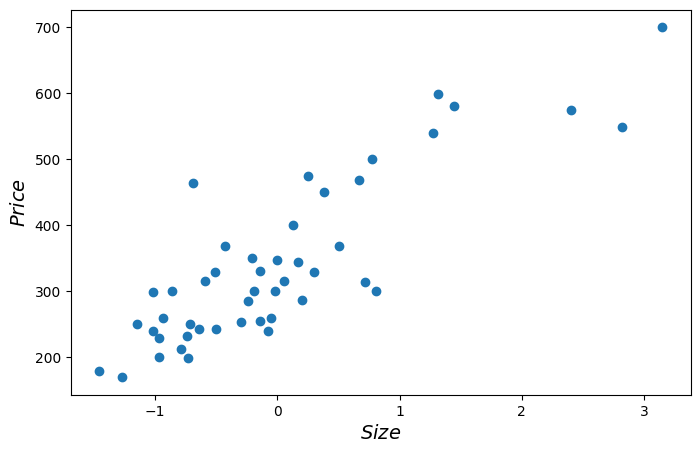

In [51]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,1], y)
plt.xlabel("$Size$", fontsize=14)
plt.ylabel("$Price$", fontsize=14)
plt.show()

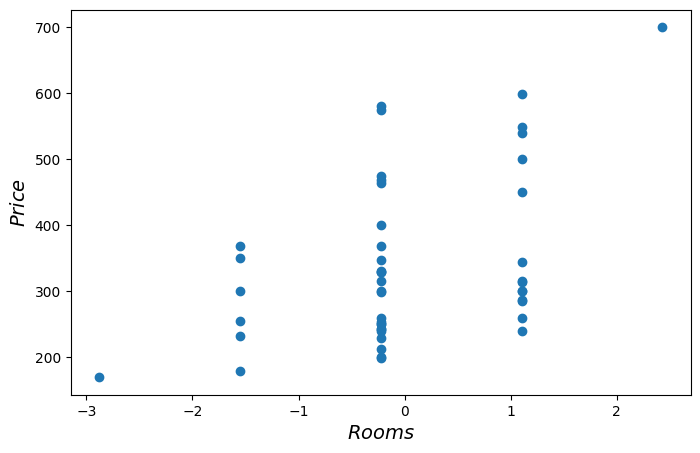

In [52]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,2], y)
plt.xlabel("$Rooms$", fontsize=14)
plt.ylabel("$Price$", fontsize=14)
plt.show()

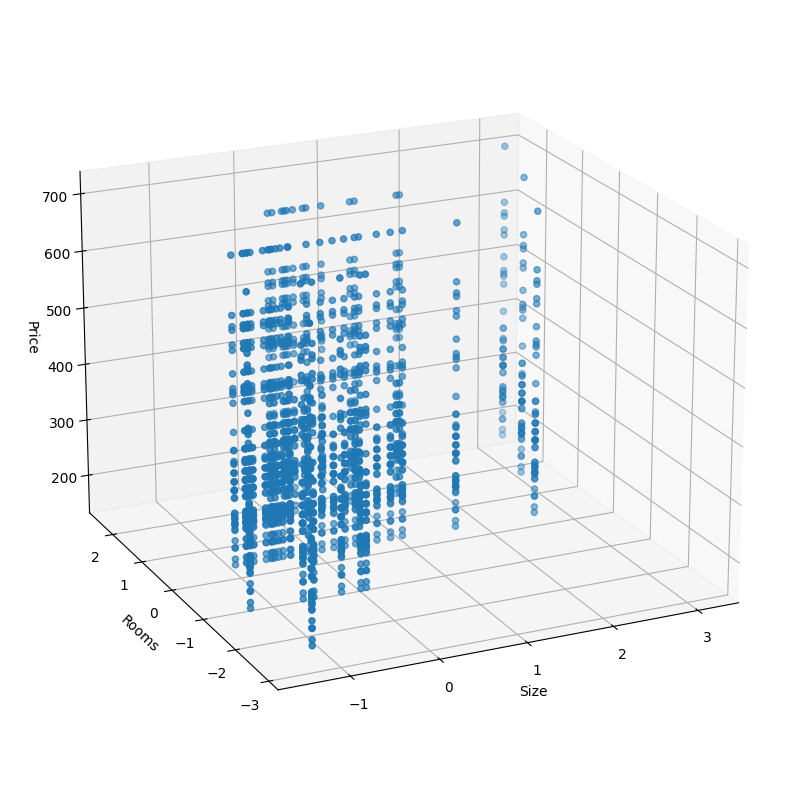

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1], X[:,2], y)
ax.set_xlabel('Size')
ax.set_ylabel('Rooms')
ax.set_zlabel('Price')
ax.view_init(20, 245)
plt.show()

### Scikit-learn

In [54]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
print(lr.intercept_, lr.coef_)

0.0 [[340.41265957 109.44779647  -6.57835485]]


$\hat{y} = 340.4127 + 109.4478 x_1 - 6.5784 x_2$

In [55]:
lr.predict(X)

array([[356.28311034],
       [286.12093063],
       [397.48946985],
       [269.24418573],
       [472.27785515],
       [330.97902102],
       [276.93302615],
       [262.03748403],
       [255.49458235],
       [271.36459919],
       [324.71454069],
       [341.80520024],
       [326.4920261 ],
       [669.29321223],
       [239.90298686],
       [374.83038333],
       [255.87996102],
       [235.44824529],
       [417.84648161],
       [476.59338604],
       [309.36911319],
       [334.95162386],
       [286.67777333],
       [327.77717552],
       [604.91337413],
       [216.51559363],
       [266.35301492],
       [415.03001477],
       [369.64733504],
       [430.48239959],
       [328.13030084],
       [220.07056445],
       [338.63560809],
       [500.0877366 ],
       [306.75636374],
       [263.42959077],
       [235.86587731],
       [351.4429901 ],
       [641.41882408],
       [355.61931032],
       [303.76843288],
       [374.93734066],
       [411.9996333 ],
       [230

### Plot the data

In [56]:
theta_hat = lr.coef_.T
theta_hat

array([[340.41265957],
       [109.44779647],
       [ -6.57835485]])

In [57]:
size_points, rooms_points = np.meshgrid([np.min(X[:,1]), np.max(X[:,1])],[np.min(X[:,2]), np.max(X[:,2])])
size_points, rooms_points

(array([[-1.46104938,  3.15099326],
        [-1.46104938,  3.15099326]]),
 array([[-2.88269044, -2.88269044],
        [ 2.4305037 ,  2.4305037 ]]))

In [58]:
price_points = theta_hat[0] + theta_hat[1] * size_points + theta_hat[2] * rooms_points

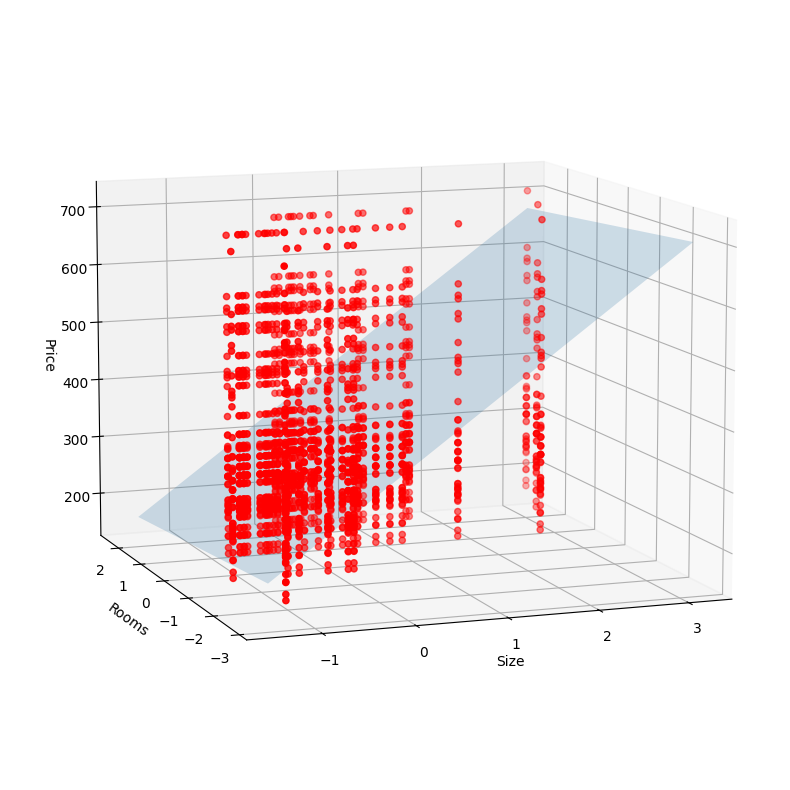

In [59]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1], X[:,2], y, c='r')
ax.set_xlabel('Size')
ax.set_ylabel('Rooms')
ax.set_zlabel('Price')
ax.plot_surface(size_points, rooms_points, price_points, alpha=0.2)
ax.view_init(10, 250)

In [60]:
import plotly.express as px
import plotly.graph_objects as go

fig_layout = go.Layout(title='Fitted model', autosize=True, width=800, height=800,
                       scene = dict(xaxis=dict(title='Size'),
                                    yaxis=dict(title='Rooms'),
                                    zaxis=dict(title='Price')))

fig = px.scatter_3d(x=X[:,1].ravel(), y=X[:,2].ravel(), z=y.ravel())
fig.update_traces(marker=dict(size=3))
fig.update_layout(fig_layout)
fig.add_traces(go.Surface(x=size_points, y=rooms_points, z=price_points, opacity=0.2))

fig.show()

### Normal equation

In [61]:
# Load the dataset
data = pd.read_csv("houses.csv", header=None, names=["Size", "Bedrooms", "Price"])

# Separate features and target
X = data[["Size", "Bedrooms"]].values
y = data["Price"].values

# Standardize the features
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_norm = (X - X_mean) / X_std

# Add the intercept term (column of ones)
m = X_norm.shape[0]
X_aug = np.hstack([np.ones((m, 1)), X_norm])

# Compute theta using the normal equation: theta = (X.T * X)^(-1) * X.T * y
theta_normal = np.linalg.inv(X_aug.T.dot(X_aug)).dot(X_aug.T).dot(y)

print("Theta (intercept, coefficients):", theta_normal)


Theta (intercept, coefficients): [340412.65957447 109447.79646964  -6578.35485416]


### SVD pseudoinverse

In [62]:
# Compute SVD of the augmented feature matrix
U, S, Vt = np.linalg.svd(X_aug, full_matrices=False)

# Compute the pseudoinverse of the singular values matrix
S_inv = np.diag(1 / S)

# Compute the pseudoinverse of X_aug: X_pinv = V * S_inv * U.T
X_pinv = Vt.T @ S_inv @ U.T

# Compute theta using the SVD pseudoinverse
theta_svd = X_pinv.dot(y)

print("Theta (intercept, coefficients):", theta_svd)


Theta (intercept, coefficients): [340412.65957447 109447.79646964  -6578.35485416]


### Gradient descent (batch)

Theta (intercept, coefficients):
 [340412.65957447 109447.79645425  -6578.35483877]


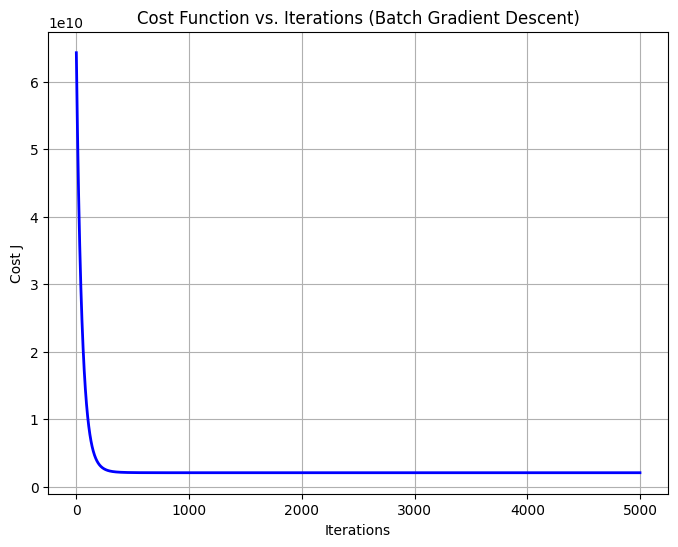

In [63]:
# Load the dataset
data = pd.read_csv("houses.csv", header=None, names=["Size", "Bedrooms", "Price"])

# Separate features and target
X = data[["Size", "Bedrooms"]].values
y = data["Price"].values.reshape(-1, 1)  # reshape to column vector

# Standardize the features
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_norm = (X - X_mean) / X_std

# Add the intercept term (column of ones)
m = X_norm.shape[0]
X_aug = np.hstack([np.ones((m, 1)), X_norm])

# Hyperparameters for gradient descent
alpha = 0.01
num_iterations = 5000

# Initialize theta (parameters) with zeros
n = X_aug.shape[1]
theta_bgd = np.zeros((n, 1))

# Function to compute the cost J
def compute_cost(X, y, theta_bgd):
    m = y.shape[0]
    predictions = X.dot(theta_bgd)
    cost = (1/(2*m)) * np.sum((predictions - y) ** 2)
    return cost

# Store cost J in every iteration for plotting
J_history = []

# Batch Gradient Descent
for i in range(num_iterations):
    predictions = X_aug.dot(theta_bgd)
    errors = predictions - y
    gradient = (1/m) * X_aug.T.dot(errors)
    theta_bgd = theta_bgd - alpha * gradient

    cost = compute_cost(X_aug, y, theta_bgd)
    J_history.append(cost)

# Print the final parameters
print("Theta (intercept, coefficients):\n", theta_bgd.flatten())

# Plot the cost function history
plt.figure(figsize=(8, 6))
plt.plot(range(num_iterations), J_history, 'b-', linewidth=2)
plt.xlabel("Iterations")
plt.ylabel("Cost J")
plt.title("Cost Function vs. Iterations (Batch Gradient Descent)")
plt.grid(True)
plt.show()


### Gradient descent (stochastic)

Epoch 1/50, Cost: 25968978344.406017
Epoch 2/50, Cost: 11507370917.596449
Epoch 3/50, Cost: 5863950186.243313
Epoch 4/50, Cost: 3575589611.590894
Epoch 5/50, Cost: 2673095640.1675425
Epoch 6/50, Cost: 2325622924.703751
Epoch 7/50, Cost: 2181995008.0136814
Epoch 8/50, Cost: 2113193457.5421937
Epoch 9/50, Cost: 2083563291.9749467
Epoch 10/50, Cost: 2065973762.1495361
Epoch 11/50, Cost: 2056670714.0255432
Epoch 12/50, Cost: 2053532385.237327
Epoch 13/50, Cost: 2052088912.7766428
Epoch 14/50, Cost: 2049141939.040021
Epoch 15/50, Cost: 2046704555.5354326
Epoch 16/50, Cost: 2045431656.6994789
Epoch 17/50, Cost: 2044344132.7695394
Epoch 18/50, Cost: 2044045848.2860503
Epoch 19/50, Cost: 2043900659.97883
Epoch 20/50, Cost: 2044693892.4159715
Epoch 21/50, Cost: 2044041421.500231
Epoch 22/50, Cost: 2045080889.8824537
Epoch 23/50, Cost: 2043659420.6023407
Epoch 24/50, Cost: 2044512642.6191516
Epoch 25/50, Cost: 2043533663.2531307
Epoch 26/50, Cost: 2043832870.5930457
Epoch 27/50, Cost: 2044737019

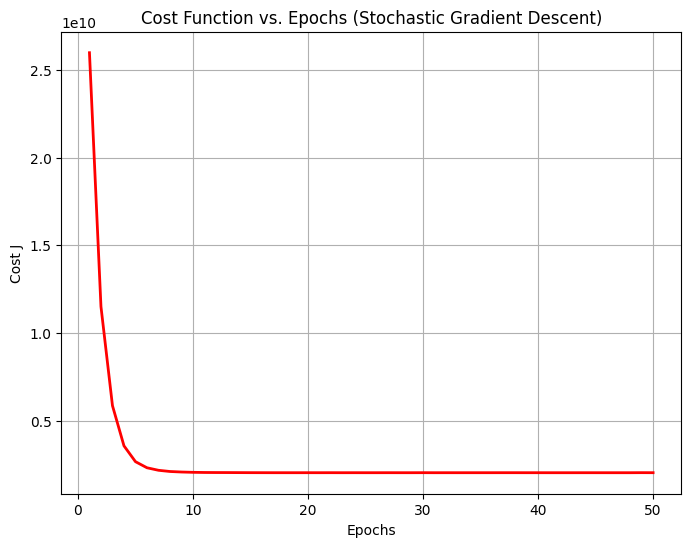

In [64]:
# Hyperparameters for stochastic gradient descent
alpha = 0.01
num_epochs = 50  # Number of passes over the entire dataset

# Initialize theta (parameters) with zeros
n = X_aug.shape[1]
theta_sgd = np.zeros((n, 1))

# Function to compute the cost J
def compute_cost(X, y, theta_sgd):
    m = y.shape[0]
    predictions = X.dot(theta_sgd)
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

# Store cost J for each epoch for plotting
cost_history = []

# Stochastic Gradient Descent
for epoch in range(num_epochs):
    # Shuffle the dataset indices
    indices = np.arange(m)
    np.random.shuffle(indices)
    X_shuffled = X_aug[indices]
    y_shuffled = y[indices]
    
    # Iterate over each training example
    for i in range(m):
        xi = X_shuffled[i, :].reshape(1, -1)  # shape (1, n)
        yi = y_shuffled[i, :].reshape(1, -1)    # shape (1, 1)
        
        # Compute prediction and error for the current example
        prediction = xi.dot(theta_sgd)
        error = prediction - yi
        
        # Update theta using the gradient computed from the current example
        theta_sgd = theta_sgd - alpha * (xi.T.dot(error))
    
    # Compute cost over the entire dataset at the end of each epoch
    cost = compute_cost(X_aug, y, theta_sgd)
    cost_history.append(cost)
    print(f"Epoch {epoch+1}/{num_epochs}, Cost: {cost}")

# Print the final parameters
print("Theta (intercept, coefficients):", theta_sgd.flatten())

# Plot the cost function history over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), cost_history, 'r-', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Cost J")
plt.title("Cost Function vs. Epochs (Stochastic Gradient Descent)")
plt.grid(True)
plt.show()


### Gradient descent (mini-batch)

Epoch 1/50, Cost: 61253629467.23869
Epoch 2/50, Cost: 57011982738.37101
Epoch 3/50, Cost: 52477731653.36895
Epoch 4/50, Cost: 47792530416.53212
Epoch 5/50, Cost: 44387930628.70918
Epoch 6/50, Cost: 40982377255.00627
Epoch 7/50, Cost: 38082426298.73972
Epoch 8/50, Cost: 34589574519.60862
Epoch 9/50, Cost: 31715665550.69458
Epoch 10/50, Cost: 29647056353.863903
Epoch 11/50, Cost: 27370670770.034847
Epoch 12/50, Cost: 25446158932.400635
Epoch 13/50, Cost: 23754748199.112366
Epoch 14/50, Cost: 22147622638.784435
Epoch 15/50, Cost: 20360195166.042355
Epoch 16/50, Cost: 19102895329.747276
Epoch 17/50, Cost: 17879797353.440147
Epoch 18/50, Cost: 16537469673.331783
Epoch 19/50, Cost: 15540943920.439491
Epoch 20/50, Cost: 14584486913.215986
Epoch 21/50, Cost: 13378603571.945995
Epoch 22/50, Cost: 12542574345.687796
Epoch 23/50, Cost: 11843034875.776459
Epoch 24/50, Cost: 10968194027.903822
Epoch 25/50, Cost: 10272680907.42169
Epoch 26/50, Cost: 9512954111.937803
Epoch 27/50, Cost: 8993769169.36

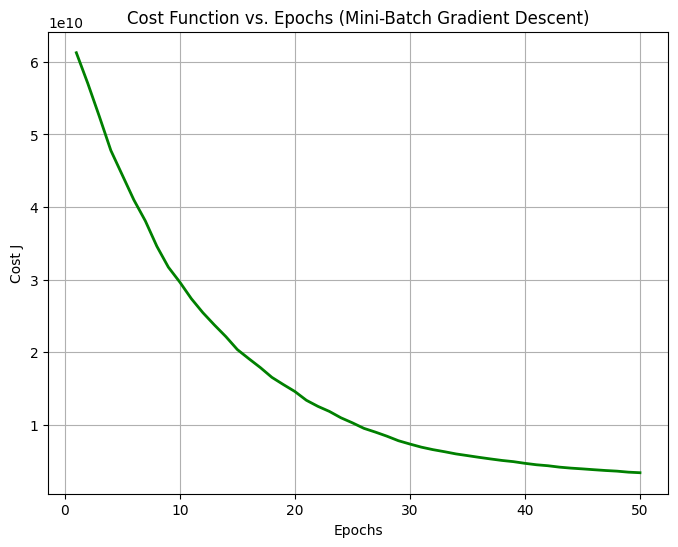

In [65]:
# Hyperparameters for mini-batch gradient descent
alpha = 0.01
num_epochs = 50   # number of passes over the entire dataset
batch_size = 15   # mini-batch size

# Initialize theta (parameters) with zeros
n = X_aug.shape[1]
theta_mbgd = np.zeros((n, 1))

# Function to compute the cost J
def compute_cost(X, y, theta_mbgd):
    m = y.shape[0]
    predictions = X.dot(theta_mbgd)
    cost = (1/(2*m)) * np.sum((predictions - y) ** 2)
    return cost

# Store cost history for each epoch
cost_history = []

# Mini-batch Gradient Descent
for epoch in range(num_epochs):
    # Shuffle the dataset indices
    indices = np.arange(m)
    np.random.shuffle(indices)
    X_shuffled = X_aug[indices]
    y_shuffled = y[indices]
    
    # Process mini-batches
    for i in range(0, m, batch_size):
        end_i = i + batch_size
        X_batch = X_shuffled[i:end_i]
        y_batch = y_shuffled[i:end_i]
        
        # Compute predictions and error for the current mini-batch
        predictions = X_batch.dot(theta_mbgd)
        errors = predictions - y_batch
        
        # Compute gradient for the mini-batch
        gradient = (1 / X_batch.shape[0]) * X_batch.T.dot(errors)
        
        # Update parameters
        theta_mbgd = theta_mbgd - alpha * gradient

    # Compute cost over the entire dataset at the end of each epoch
    cost = compute_cost(X_aug, y, theta_mbgd)
    cost_history.append(cost)
    print(f"Epoch {epoch+1}/{num_epochs}, Cost: {cost}")

# Print the final parameters
print("Theta (intercept, coefficients):", theta_mbgd.flatten())

# Plot the cost function history over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), cost_history, 'g-', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Cost J")
plt.title("Cost Function vs. Epochs (Mini-Batch Gradient Descent)")
plt.grid(True)
plt.show()


### Compare parameters

In [66]:
print(f"""
{'='*10} Valores Theta {'='*10}
Normal: {theta_normal}

SVD: {theta_svd}

Batch Gradient Descent: {theta_bgd}

Stochastic Gradient Descent: {theta_sgd}

Mini-Batch Gradient Descent: {theta_mbgd}
""")


========== Valores Theta ==========
Normal: [340412.65957447 109447.79646964  -6578.35485416]

SVD: [340412.65957447 109447.79646964  -6578.35485416]

Batch Gradient Descent: [[340412.65957447]
 [109447.79645425]
 [ -6578.35483877]]

Stochastic Gradient Descent: [[340710.8737869 ]
 [110091.15591912]
 [ -5473.51115176]]

Mini-Batch Gradient Descent: [[293095.38170932]
 [ 84627.87864654]
 [ 14407.23379691]]



## Authors:
- Caballero Coll Alejandro
- Chiquete Ayala Paulina
- Dominguez Jaber Teresa Estefania 
- Monroy Minero Diego
- Valbuena Novelo Alan Alberto